In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here""s several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


In [2]:
pd.options.mode.chained_assignment = None

# Careful preprocessing and embedding are all you need :)

The aim of this notebook is to test the hypothesis that to classify proteins on this dataset, it is sufficient to carefully preprocess the data and 
have a very simple model whose key component is an **embedding layer**.

To test this hypothesis, we will:
* Carefully examine the data and preprocess it.
* Construct a simple baseline neural network with just an embedding layer, single hidden layer and a classification head.
* Examine the need for learnable positional embedding.
* Based on the baseline, construct a more complex model based on (positional) embedding and transformer and compare it to the simple baseline.
* Evaluate results and discuss validity of the hypothesis.

Note that, due to computational limitations, this is a proof of concept, not a sophisticated and rigorous analysis.

### Some imports

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

# plt.style.use("seaborn-whitegrid")
sns.set_style()

In [4]:
dataset_path = "/kaggle/input/pfam-seed-random-split/random_split"

To begin, let us create a simple **load_dataset** helper to load the data.

In [5]:
import pandas as pd
import glob

def load_dataset(split: str):
    data_chunks = glob.glob(f"{dataset_path}/{split}/*")
    read_data_chunks = [pd.read_csv(data_chunk) for data_chunk in data_chunks]
    read_df = pd.concat(read_data_chunks, ignore_index=True)
    read_df["split"] = split
    return read_df

In [6]:
raw_train_df = load_dataset("train")
raw_dev_df = load_dataset("dev")
raw_test_df = load_dataset("test")

In [7]:
raw_train_df.head()

,family_id,sequence_name,family_accession,aligned_sequence,sequence,split
0,YfcL,Q5E3V0_VIBF1/3-85,PF08891.11,IEFEEKMLELIDARIESASD.DELFAGGYLRGHISLSVANCEEQGI...,IEFEEKMLELIDARIESASDDELFAGGYLRGHISLSVANCEEQGIN...,train
1,Somatomedin_B,F2UGX0_SALR5/258-297,PF01033.17,TTCAVRG...C..........SDINL......NQNCQCD.PSC.YS...,TTCAVRGCSDINLNQNCQCDPSCYSFGDCCADFAAVCESS,train
2,Surp,K7J3U9_NASVI/11-59,PF01805.20,RNIIDKLAQFVA..R..NG....P........EFEQMT.KNK.......,RNIIDKLAQFVARNGPEFEQMTKNKQKDNPKFSFLFGGEYFNYYQYKVT,train
3,DUF1230,E1ZG39_CHLVA/70-212,PF06799.11,.AVPREQRPVNELQQLKDTPLLAW......ATLDL..PQYAQRL.....,AVPREQRPVNELQQLKDTPLLAWATLDLPQYAQRLLILYGGVFLLL...,train
4,SRCR_2,F1NY88_CHICK/145-241,PF15494.6,GPNFILEVYSPVSQTWYPVCQDDWTDDFGKIACEDMGYN....VDT...,GPNFILEVYSPVSQTWYPVCQDDWTDDFGKIACEDMGYNVDTYYYS...,train


Our task is to predict **family_accession** given the **sequence**.

## Dataset Analysis

### Dataset split

We start the dataset analysis by examining percentage of data in each of **train**, **dev** and **test** split.

In [8]:
raw_all_df = pd.concat([raw_train_df, raw_dev_df, raw_test_df])

In [9]:
train_split_ratio = np.round((len(raw_train_df)/ len(raw_all_df)) * 100, 2)
dev_split_ratio = np.round((len(raw_dev_df)/ len(raw_all_df)) * 100, 2)
test_split_ratio = np.round((len(raw_test_df)/ len(raw_all_df)) * 100, 2)

pd.DataFrame({
    "split": ["train", "dev", "test"],
    "percentage of all data": [train_split_ratio, dev_split_ratio, test_split_ratio]
})

,split,percentage of all data
0,train,81.16
1,dev,9.42
2,test,9.42


### Label distribution

Now, let us examine the distribution of labels. This is important because we may have to deal with imbalanced labels, which could affect our choice of model, training sampling method and the loss function.

In [10]:
train_labels = np.unique(raw_train_df["family_accession"])
dev_labels = np.unique(raw_dev_df["family_accession"])
test_labels = np.unique(raw_test_df["family_accession"])
all_labels = np.unique(raw_all_df["family_accession"])

In [11]:
pd.DataFrame({
    "split" : ["dev", "test"],
    "training set coverage": [
        np.isin(dev_labels, train_labels).sum() / len(dev_labels), 
        np.isin(test_labels, train_labels).sum() / len(test_labels)
    ]
})

,split,training set coverage
0,dev,1.0
1,test,1.0


Training set covers all possible labels in dev and test. 
This is good. Now, let us consider the frequency of each **family_accession** label.

<AxesSubplot:xlabel='family_accession'>

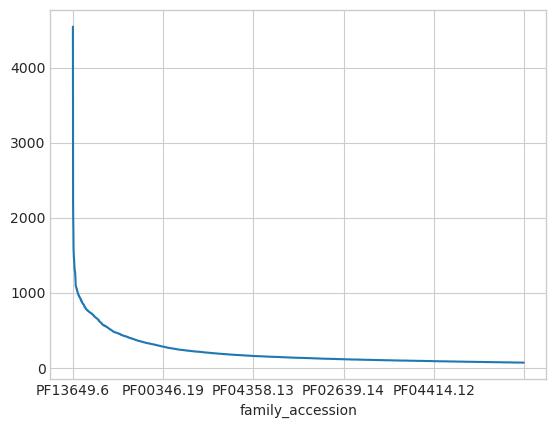

In [12]:
labels_count  = raw_all_df.value_counts("family_accession")
labels_count_to_plot = labels_count.iloc[:5000]
labels_count_to_plot.plot()

In [13]:
print(f"The label with the most seqs is {labels_count.index[0]} and it has {labels_count[0]} seqs.")
for i in [10, 50, 100, 150, 200, 250, 500, 1000]:
    print(f"The label with the {i}th most seqs is {labels_count.index[i]} and it has {labels_count[i-1]} seqs.")

The label with the most seqs is PF13649.6 and it has 4545 seqs.

The label with the 10th most seqs is PF02881.19 and it has 1512 seqs.

The label with the 50th most seqs is PF03948.14 and it has 1017 seqs.

The label with the 100th most seqs is PF02912.18 and it has 884 seqs.

The label with the 150th most seqs is PF01379.20 and it has 780 seqs.

The label with the 200th most seqs is PF01169.19 and it has 731 seqs.

The label with the 250th most seqs is PF16344.5 and it has 675 seqs.

The label with the 500th most seqs is PF17757.1 and it has 461 seqs.

The label with the 1000th most seqs is PF00346.19 and it has 284 seqs.


Results above indicate that our dataset is quite imbalanced, and imbalance is significant. Note that the most frequent label has 4545 seqs while 1000th most frequent has only 284.

Apart from that, the number of labels is very large. If we were to predict probability for each label, the output would need to have dimension of **num_labels**. 
This will result in a massive number of parameters, which can lead to **overfitting** and will have considerable computational cost.
Apart from that, such a large number of labels is a big issue for popular **softmax** activation function, due to time complexity and numerical stability.
Given the constraints of this notebook environment and time, we will build a classification model on **top 64 classes**.
In real-world environment, I would build a coarse-grained classification model that predicts a label representing a "groups of labels".
Then, I would build smaller classification models that are more fine-grained, for each "group of labels".

([], [])

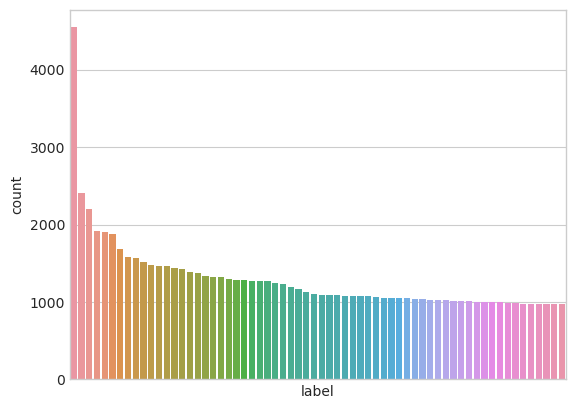

In [14]:
num_labels = 64

top_labels_df = pd.DataFrame({
    "label":  labels_count_to_plot.iloc[:num_labels].index.to_list(),
    "count" : labels_count_to_plot.iloc[:num_labels].to_list()
})

sns.barplot(x = "label", y="count", data=top_labels_df)
plt.xticks([])

Plot above indicates that when considering top 64 labels, number of sequences per label is quite balanced, except possibly for top 5 most frequent labels.

Now, let us preprocess the dataset to consider only top 64 most frequent labels.

In [15]:
top_labels_df

,label,count
0,PF13649.6,4545
1,PF00560.33,2407
2,PF13508.7,2199
3,PF06580.13,1921
4,PF02397.16,1908
...,...,...
59,PF01458.17,978
60,PF04122.12,975
61,PF05697.13,971
62,PF02777.18,971


In [16]:
most_common_labels = top_labels_df.label.to_list()


In [17]:
def select_most_frequent_labels(dataset):
    mask = dataset.family_accession.isin(most_common_labels)
    return dataset.loc[mask, :]

train_df = select_most_frequent_labels(raw_train_df)
dev_df = select_most_frequent_labels(raw_dev_df)
test_df = select_most_frequent_labels(raw_test_df)
all_df = pd.concat([train_df, dev_df, test_df])
train_df.head()

,family_id,sequence_name,family_accession,aligned_sequence,sequence,split
5,WD40,SRW1_SCHPO/406-447,PF00400.32,EKPLYS..F....H.....NH......IA...........AV...K...,EKPLYSFHNHIAAVKAITWSPHQRGILASGGGTADRTIKLWN,train
24,UbiA,X5A117_9BACL/24-271,PF01040.18,AFMGAL.LG.......SMVMSGSLP..SW............RDIGW...,AFMGALLGSMVMSGSLPSWRDIGWIIIAMFGARSAAMGLNRLIDRV...,train
52,DnaJ_CXXCXGXG,M1E599_9FIRM/142-205,PF00684.19,CEKCE.GKG.....S..V.S..GRK.....V....V.CKVCHGTG....,CEKCEGKGSVSGRKVVCKVCHGTGQVTSSRRTILGNVYQTYSCPEC...,train
56,WD40,Q93339_CAEEL/328-366,PF00400.32,KKELLY..Q....E.....GH....SKS.............V...A...,KKELLYQEGHSKSVADVAFHPDGSVALTGGHDCYGRVWD,train
69,Chromate_transp,W5V149_9MOLU/17-179,PF02417.15,..VLWFVVKLSLISFGGGNAMM.PIAYQQA........VE.........,VLWFVVKLSLISFGGGNAMMPIAYQQAVEKKKWLEKHEFDDVVVMA...,train


Now, let us reconsider train, dev and test split ratio.

In [18]:
train_split_ratio = np.round((len(train_df)/ len(all_df)) * 100, 2)
dev_split_ratio = np.round((len(dev_df)/ len(all_df)) * 100, 2)
test_split_ratio = np.round((len(test_df)/ len(all_df)) * 100, 2)

pd.DataFrame({
    "split": ["train", "dev", "test"],
    "percentage of all data": [train_split_ratio, dev_split_ratio, test_split_ratio]
})

,split,percentage of all data
0,train,80.07
1,dev,9.97
2,test,9.97


Results are almost identical to the split before pre-processing. We may continue with this split.

### Sequence length distribution

Since we are dealing with protein sequences, we expect to see variable sequence lengths. 
Let us examine whether that is indeed the case.

Text(0.5, 1.0, 'Sequence length distribution')

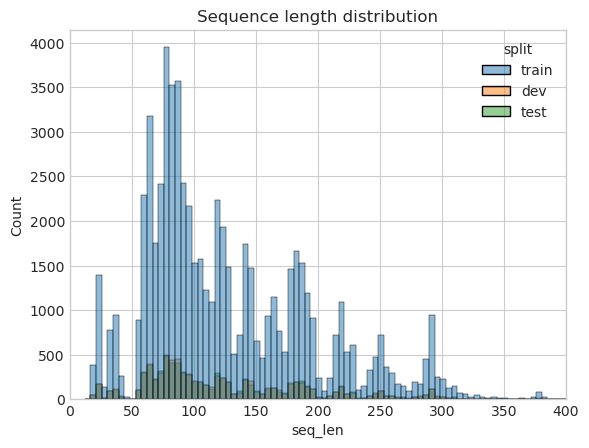

In [19]:
def compute_seq_lens(df):
    return pd.DataFrame({
        "split": df["split"].to_list(),
        "seq_len" : df["sequence"].apply(len).to_list()
    })

train_seq_lens = compute_seq_lens(train_df)
dev_seq_lens =  compute_seq_lens(dev_df)
test_seq_lens =  compute_seq_lens(test_df)

seq_lens_grouped_by_split = pd.concat([
    train_seq_lens,
    dev_seq_lens,
    test_seq_lens
])
sns.histplot(data=seq_lens_grouped_by_split, x="seq_len", hue="split", bins=100)
plt.xlim((0, 400))
plt.title("Sequence length distribution")

Indeed, sequence lengths are quite variable and it seems that most of sequences have length in range 50-150.

Thus, to reduce computational complexity, we will **truncate and pad sequences to length of 300**.

### Amino acids distribution

Another important property of protein sequence dataset is the distribution of amino acids.
Let us examine it.

<AxesSubplot:xlabel='acid', ylabel='freq'>

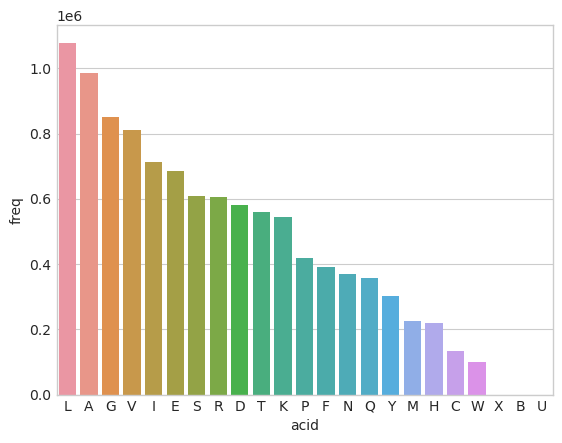

In [20]:
from collections import Counter
def compute_aminoacids_freq(df):
    freq_per_acid = Counter("".join(df["sequence"]))
    freq_df = pd.DataFrame({
        "acid": list(freq_per_acid.keys()), 
        "freq": list(freq_per_acid.values())
    })
    return freq_df.sort_values("freq", ascending=False).reset_index()[["acid", "freq"]]

amino_acids_freq_df = compute_aminoacids_freq(all_df)

sns.barplot(x="acid", y="freq", data=amino_acids_freq_df)

The results above indicate imbalanced frequencies of amino acids.
Note that **X, U, B** have **a very small number of occurences** and **O, Z** do not even appear in our filtered dataset.

Since we cannot make reliable predictions based on such a small number of occurences, we will **simply remove (ignore) them**.

To recap, we will solve imbalanced frequencies of amino acids by ignoring all such and we will pad/truncate all sequences to be of length precisely **300**.

Let us perform this preprocessing step.

In [21]:
frequent_acids = amino_acids_freq_df.acid.to_list()[:-3]


We will build a lookup table acid -> integer index and map all not frequent acids to index zero.

In [22]:
def build_acid_lookup_table(acids):
    acid_index = {}
    for ix, acid in enumerate(acids):
        acid_index[acid] = ix + 1
    return acid_index

acid_index = build_acid_lookup_table(frequent_acids)
acid_index

{'L': 1,
 'A': 2,
 'G': 3,
 'V': 4,
 'I': 5,
 'E': 6,
 'S': 7,
 'R': 8,
 'D': 9,
 'T': 10,
 'K': 11,
 'P': 12,
 'F': 13,
 'N': 14,
 'Q': 15,
 'Y': 16,
 'M': 17,
 'H': 18,
 'C': 19,
 'W': 20}

In [23]:
def int_encode(df):
    encoded = []
    not_frequent_acid_index = 0
    for seq in df["sequence"]:
        encoded.append(
            np.array([acid_index.get(acid, not_frequent_acid_index) for acid in seq])
        )

    return encoded

Now perform integer encoding.

In [24]:
train_seqs_enc = int_encode(train_df)
dev_seqs_enc = int_encode(dev_df)
test_seqs_enc = int_encode(test_df)

Now perform padding.

In [25]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_seq_len = 300

train_seqs_enc_pad = pad_sequences(
    train_seqs_enc, 
    maxlen=max_seq_len, 
    padding="post", 
    truncating="post"
)
dev_seqs_enc_pad = pad_sequences(
    dev_seqs_enc, 
    maxlen=max_seq_len, 
    padding="post",
    truncating="post"
)
test_seqs_enc_pad = pad_sequences(
    test_seqs_enc, 
    maxlen=max_seq_len, 
    padding="post", 
    truncating="post"
)
print(train_seqs_enc_pad.shape, dev_seqs_enc_pad.shape, test_seqs_enc_pad.shape)

(66321, 300) (8256, 300) (8256, 300)


Introduce common input naming convention.

In [26]:
x_train = train_seqs_enc_pad
x_dev = dev_seqs_enc_pad
x_test = test_seqs_enc_pad
print(x_train.shape, x_dev.shape, x_test.shape)

(66321, 300) (8256, 300) (8256, 300)


Now let us one-hot encode corresponding labels.

In [27]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

label_encoder = LabelEncoder().fit(all_df.family_accession)

y_train = label_encoder.transform(train_df.family_accession)
y_dev = label_encoder.transform(dev_df.family_accession)
y_test = label_encoder.transform(test_df.family_accession)

y_train = to_categorical(y_train)
y_dev = to_categorical(y_dev)
y_test = to_categorical(y_test)

print(y_train.shape, y_dev.shape, y_test.shape)

(66321, 64) (8256, 64) (8256, 64)


Since our dataset is label-imbalanced, let us estimate **label_weights** for train dataset and use them in our training sampling.

In [28]:
from sklearn.utils import class_weight

discretized_labels = np.argmax(y_train, axis=1)

label_weights = class_weight.compute_class_weight(
    class_weight="balanced", 
    classes=np.unique(discretized_labels), 
    y=discretized_labels
)
label_weights = dict(enumerate(label_weights))

### Helpers

We will create a simple helper for plotting learning curves.

In [29]:
def plot_history(history):
    fig, (loss_plot, acc_plot) = plt.subplots(1, 2, figsize=(9, 4))
    fig.suptitle("learning curves")
    
    loss_plot.plot(history.history["loss"])
    loss_plot.plot(history.history["val_loss"])
    loss_plot.set_ylabel("loss")
    loss_plot.set_xlabel("epoch")
    loss_plot.legend(["train", "val"], loc="upper right")
    
    acc_plot.plot(history.history["accuracy"])
    acc_plot.plot(history.history["val_accuracy"])
    acc_plot.set_ylabel("accuracy")
    acc_plot.set_xlabel("epoch")
    acc_plot.legend(["train", "val"], loc="lower right")

We will create a simple helper to plot some embeddings.

In [31]:
from sklearn.manifold import TSNE
def visualize_seq_embeddings(model, num_most_frequent_labels):
    
    batch_size = 256
    
    x_test_pre_class_embeds = []
    
    test_dataset = tf.data.Dataset.from_tensor_slices(x_test)
    test_dataset = test_dataset.batch(batch_size)
    for x_batch in test_dataset.as_numpy_iterator():
        x_test_pre_class_embeds.append(model.get_seq_embeddings(x_batch))
    
    x_test_pre_class_embeds = np.vstack(x_test_pre_class_embeds)
    x_test_tsne = TSNE(n_components=2,random_state=420).fit_transform(x_test_pre_class_embeds)
    
    plot_df = test_df[["family_accession"]]
    plot_df["PC1"] = x_test_tsne[:,0]
    plot_df['PC2'] = x_test_tsne[:,1]
    plot_df_top_label= plot_df.loc[plot_df.family_accession.isin(most_common_labels[:num_most_frequent_labels])]
    plot_df_top_label.reset_index(inplace=True)
    plt.rcParams.update({'font.size': 12})
    plt.figure(figsize=(8,8))
    sns.jointplot(data=plot_df_top_label, x='PC1', y='PC2', hue = 'family_accession', height=10)

### Positional Encoding Layer

This is a standard implementation of positional encoding layer.

In [32]:
import tensorflow as tf
import tensorflow.keras.layers as layers

class PositionEmbeddingLayer(layers.Layer):
    def __init__(self, seq_length, input_dim, embedding_dim, **kwargs):
        super(PositionEmbeddingLayer, self).__init__(**kwargs)
        self.acid_embedding = Embedding(
            input_dim=input_dim, 
            output_dim=embedding_dim
        )
        self.pos_encoding = Embedding(
            input_dim=seq_length, 
            output_dim=embedding_dim
        )
 
    def call(self, inputs):
        seq_dim = tf.shape(inputs)[-1]
        position_indices = tf.range(seq_dim)
        acid_embeddings = self.acid_embedding(inputs)
        pos_encodings = self.pos_encoding(position_indices)
        return acid_embeddings + pos_encodings

## Method explanation
* To verify the hypothesis, we will build **three models**, of increasing complexity.
* We will start with a **simple baseline** neural network, consisting of **embedding layer**, **hidden layer** and **the classification head**.
* We will examine the importance of **positional embedding** by replacing the embedding layer with a learnable positional embedding layer in the model above.
* Finally, we will introduce a stack of **transformer layers** between the amino acid embedding layer and hidden layer. Then we will examine performance impact of this complexity increase.

We will perform quantitative and qualitative analysis on each experiment (model). Quantitative analysis will simply be the analysis of accuracy on the test set,
while qualitative analysis will be based on embedding visualisation. 
To gain intuition about decisions of our models, we will visualize outputs of the layer immediatelly before the classification head.
We can treat those outputs as embeddings of whole sequences. We will use t-SNE to visualise those outputs and try to interpret results.

The hypothesis can be verified by showing that following holds experimentally:
* Simple neural network described above generalizes really well.
* Visualized sequence embeddings show clear evidence of structure.
* Introducing more complexity to the model does not yield significantly stronger model.

Why transformers? Observe that after introducing embedding layer, protein classification task can be seen as a sentence classification task, by treating amino acids as words and protein sequences as sentences.
Note that attention allows the transformer to immediatelly look at entire protein sequence and consequently learn pairwise interactions and importance. This seems as an useful inductive bias.
An alternative is to use LSTMs, GRUs and other variants of recurrent models. However, those are known to have limited memory and they are known to suffer from vanishing gradients. 
Since our protein sequences are precisely 300 characters long, it is reasonable to conjecture that recurrent architectures will not be able to remember entire sequence.
Thus, I went for transformers as more complex models.

### References
- The implementation of Transformer Layer will be based on Attention is all you need (https://arxiv.org/abs/1706.03762). However, I will use more recent pre-norm adaptation.
- Some preprocessing code in the section above was adapted from https://www.kaggle.com/code/henrikhl/pfam-classification.

## Experiment Description

As suggested in **Method explanation**, we will carry out three experiments. Those will be:
* Simple Baseline 
* Baseline with Positional Embedding
* Transformer with Positional Embedding

### Simple Baseline

#### Model Parameters

In [33]:
embedding_dim = 32
input_dim=len(acid_index) + 1

#### Training config

In [34]:
max_epochs = 10
batch_size = 32
patience = 5

In [35]:
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten
from tensorflow.keras.layers import Embedding
import tensorflow as tf

class Baseline(tf.keras.Model):
    def __init__(self, input_dim, embedding_dim, out_dim, max_seq_len, dropout_rate=0.2, embedding_type="vanilla"):
        super(Baseline, self).__init__()
        self.max_seq_len = max_seq_len
        self.input_dim = input_dim
        self.embedding_dim = embedding_dim
        if embedding_type == "positional":
            self.embedding = PositionEmbeddingLayer(
                seq_length = max_seq_len, 
                input_dim = len(acid_index) + 1, 
                embedding_dim = embedding_dim
            )
        else:
            self.embedding = Embedding(input_dim=input_dim, output_dim=embedding_dim)
        self.flatten = Flatten()
        self.embedding_dropout = Dropout(dropout_rate)
        self.embedding_proj = Dense(128, activation="gelu")
        self.embedding_proj_dropout = Dropout(dropout_rate)
        self.classifier = Dense(out_dim, activation="softmax")
        
    def get_seq_embeddings(self, x, training=False):
        x = self.embedding(x)
        x = self.embedding_dropout(x, training)
        x = self.flatten(x)
        x = self.embedding_proj(x)
        x = self.embedding_proj_dropout(x, training)
        return x
    
    def call(self, inputs, training=False):
        return self.classifier(self.get_seq_embeddings(inputs, training))
    
baseline_model = Baseline(input_dim, embedding_dim, num_labels, max_seq_len)
baseline_model(x_train[:0])
baseline_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
baseline_model.summary()

Model: "baseline"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 embedding (Embedding)       multiple                  672       

                                                                 

 flatten (Flatten)           multiple                  0         

                                                                 

 dropout (Dropout)           multiple                  0         

                                                                 

 dense (Dense)               multiple                  1228928   

                                                                 

 dropout_1 (Dropout)         multiple                  0         

                                                                 

 dense_1 (Dense)             multiple                  8256      

                                                                 


Total params: 1,237,856

Trainable params

As we can see in the summary above, baseline is quite simple. Key parts of the model are **embedding layer**, **hidden layer** and **classifier** head.
Now let us fit the model.

In [36]:
baseline_history = baseline_model.fit(
    x_train, 
    y_train,
    epochs=max_epochs, 
    batch_size=batch_size,
    validation_data=(x_dev, y_dev),
    class_weight=label_weights,
    callbacks=[EarlyStopping(
        monitor="val_loss", 
        patience=patience, 
        restore_best_weights=True, 
        verbose=1
    )]
)

Epoch 1/10

2073/2073 [==============================] - 11s 4ms/step - loss: 0.1892 - accuracy: 0.9564 - val_loss: 0.0180 - val_accuracy: 0.9953

Epoch 2/10

2073/2073 [==============================] - 8s 4ms/step - loss: 0.0070 - accuracy: 0.9981 - val_loss: 0.0167 - val_accuracy: 0.9959

Epoch 3/10

2073/2073 [==============================] - 8s 4ms/step - loss: 0.0071 - accuracy: 0.9981 - val_loss: 0.0244 - val_accuracy: 0.9943

Epoch 4/10

2073/2073 [==============================] - 9s 4ms/step - loss: 0.0071 - accuracy: 0.9977 - val_loss: 0.0255 - val_accuracy: 0.9952

Epoch 5/10

2073/2073 [==============================] - 9s 4ms/step - loss: 0.0058 - accuracy: 0.9983 - val_loss: 0.0235 - val_accuracy: 0.9956

Epoch 6/10

2073/2073 [==============================] - 8s 4ms/step - loss: 0.0068 - accuracy: 0.9978 - val_loss: 0.0238 - val_accuracy: 0.9956

Epoch 7/10

2069/2073 [============================>.] - ETA: 0s - loss: 0.0064 - accuracy: 0.9982Restoring model weights f

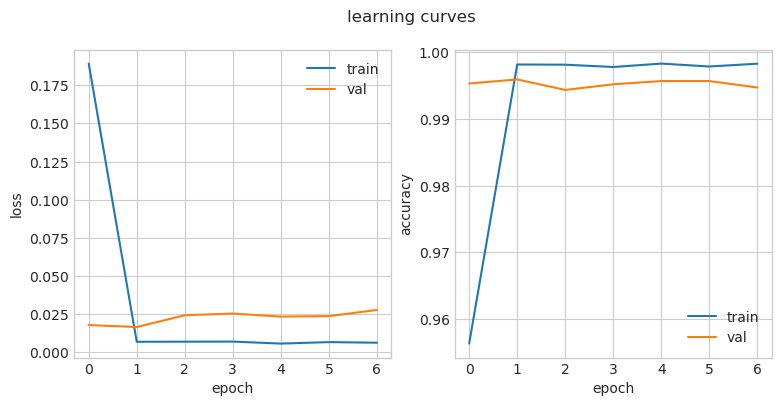

In [37]:
plot_history(baseline_history)

It seems that the model starts overfitting quite early. This makes sense, as we did not set up a lot of regularization. 
However, we are fine since we are using early stopping and validation accuracy seems promising.

Now, let us examine the performance of this simple model on the test set.

In [38]:
baseline_model.evaluate(x_test, y_test, batch_size=batch_size, verbose=1)

258/258 [==============================] - 1s 3ms/step - loss: 0.0129 - accuracy: 0.9969


[0.01288346853107214, 0.9968507885932922]

In my opinion, test performance of such a simple model is quite surprising.
Let us visualise pre-classifier embeddings (embeddings of each sequence) to get some intuition about our model.


/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

  FutureWarning,

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

  FutureWarning,


<Figure size 800x800 with 0 Axes>

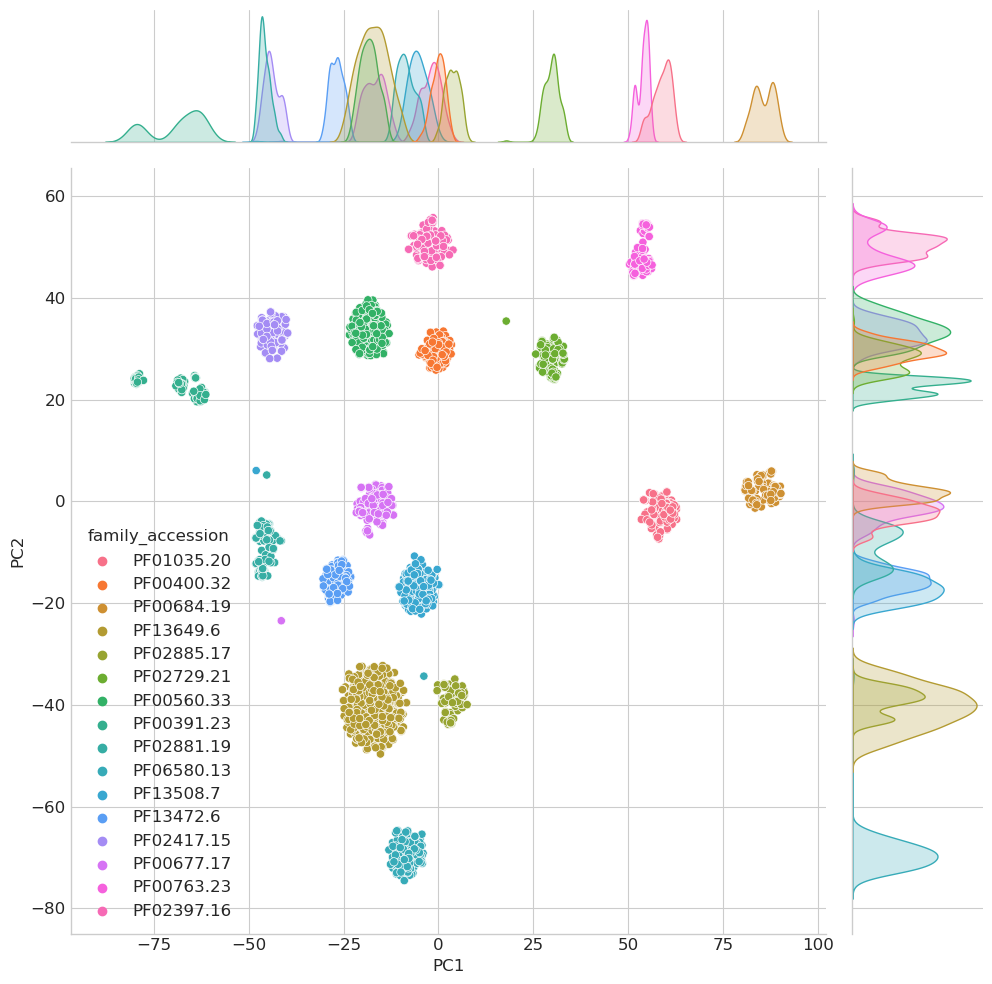

In [39]:
visualize_seq_embeddings(baseline_model, num_most_frequent_labels=16)

According to the plot above, the model projects sequences belonging to different labels far away from each other.
Apart from that, we can see clusters of sequences belonging to the same label, and clusters are nicely separated.

This is consistent with excellent performance on the test set. 
Given such a good clustering, it is plausible that a very good classifier can be learned.

### Baseline with Positional Embedding

Note that the baseline model does not know about position of acids. 
To try to improve it, let us replace the embedding layer with a learnable positional embedding and see what happens.

In [40]:
positional_model = Baseline(input_dim, embedding_dim, num_labels, max_seq_len, embedding_type="positional")
positional_model(x_train[:0])
positional_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
positional_model.summary()

Model: "baseline_1"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 position_embedding_layer (P  multiple                 10272     

 ositionEmbeddingLayer)                                          

                                                                 

 flatten_1 (Flatten)         multiple                  0         

                                                                 

 dropout_2 (Dropout)         multiple                  0         

                                                                 

 dense_2 (Dense)             multiple                  1228928   

                                                                 

 dropout_3 (Dropout)         multiple                  0         

                                                                 

 dense_3 (Dense)             multiple                  8256      

                                        

In [41]:
positional_history = positional_model.fit(
    x_train, 
    y_train,
    epochs=max_epochs, 
    batch_size=batch_size,
    validation_data=(x_dev, y_dev),
    class_weight=label_weights,
    callbacks=[EarlyStopping(
        monitor="val_loss", 
        patience=patience, 
        restore_best_weights=True, 
        verbose=1
    )]
)

Epoch 1/10

2073/2073 [==============================] - 11s 5ms/step - loss: 0.2100 - accuracy: 0.9503 - val_loss: 0.0156 - val_accuracy: 0.9955

Epoch 2/10

2073/2073 [==============================] - 9s 4ms/step - loss: 0.0095 - accuracy: 0.9976 - val_loss: 0.0136 - val_accuracy: 0.9969

Epoch 3/10

2073/2073 [==============================] - 10s 5ms/step - loss: 0.0103 - accuracy: 0.9969 - val_loss: 0.0226 - val_accuracy: 0.9950

Epoch 4/10

2073/2073 [==============================] - 9s 4ms/step - loss: 0.0103 - accuracy: 0.9968 - val_loss: 0.0218 - val_accuracy: 0.9954

Epoch 5/10

2073/2073 [==============================] - 9s 4ms/step - loss: 0.0090 - accuracy: 0.9970 - val_loss: 0.0210 - val_accuracy: 0.9967

Epoch 6/10

2073/2073 [==============================] - 9s 5ms/step - loss: 0.0123 - accuracy: 0.9967 - val_loss: 0.0206 - val_accuracy: 0.9966

Epoch 7/10

2067/2073 [============================>.] - ETA: 0s - loss: 0.0107 - accuracy: 0.9972Restoring model weights 

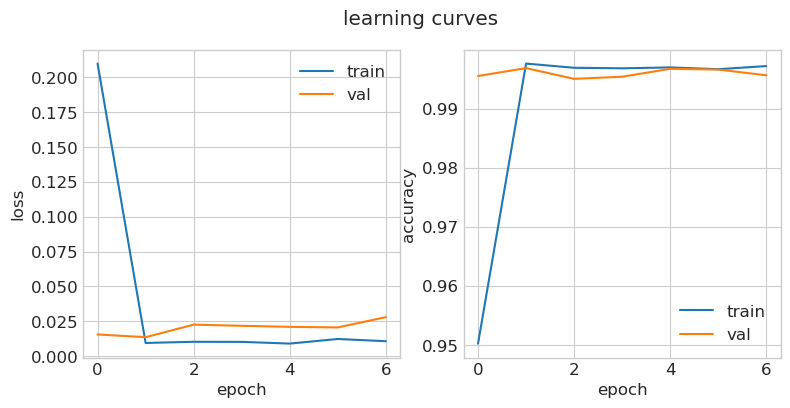

In [42]:
plot_history(positional_history)

It seems that the model starts overfitting quite early. This makes sense, as we did not set up a lot of regularization. 
However, we are fine since we are using early stopping, and validation accuracy still seems promising.

In [43]:
positional_model.evaluate(x_test, y_test, batch_size=batch_size, verbose=1)

258/258 [==============================] - 1s 2ms/step - loss: 0.0119 - accuracy: 0.9967


[0.011908341199159622, 0.9967296719551086]

Interestingly, performance did not improve significantly. Moreover, it is slightly worse. I would assume that positional information is very important for classifying sequences, but this result indicates otherwise.
I repeated this experiment 10 times. I never managed to beat the baseline.

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

  FutureWarning,

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

  FutureWarning,


<Figure size 800x800 with 0 Axes>

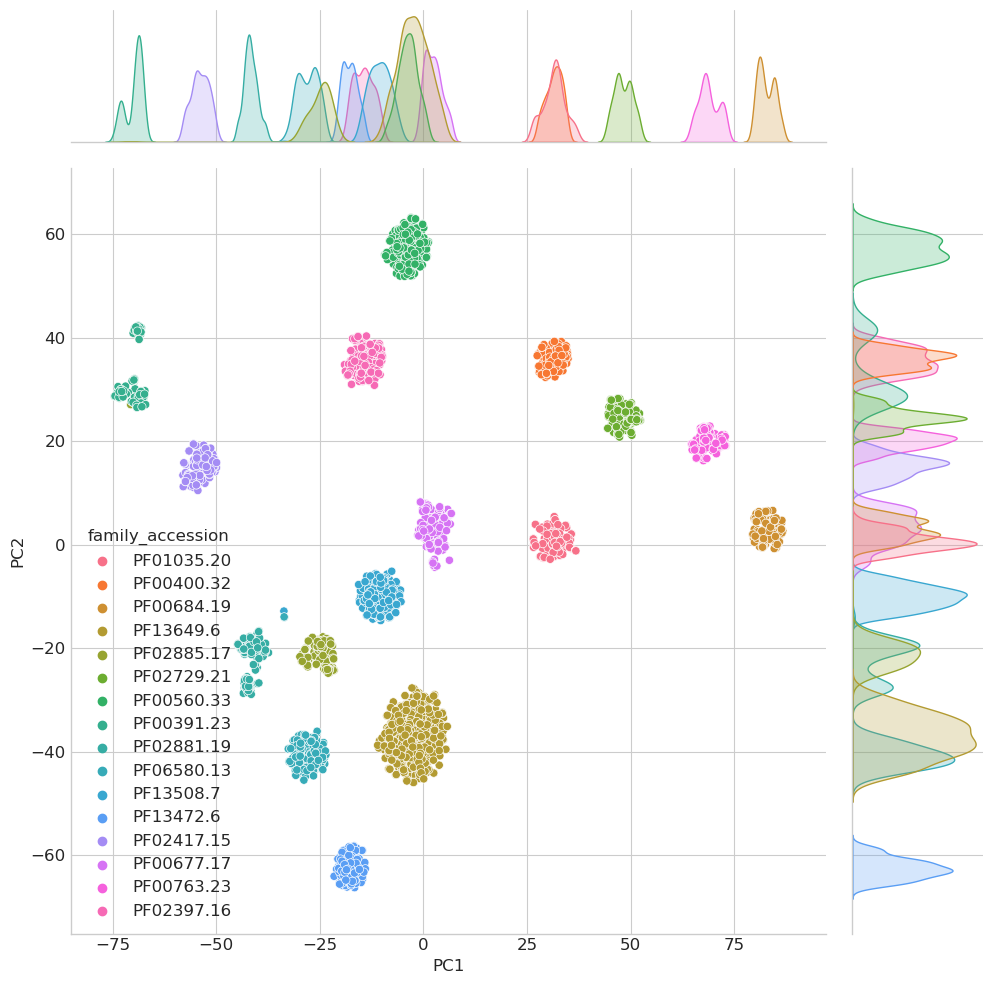

In [44]:
visualize_seq_embeddings(positional_model, num_most_frequent_labels=16)

As in the baseline model, clusters of sequences belonging to the same label are very nicely separated, indicating that the embedding layer does a great job.

### Transformer Encoder

Let us try to improve the performance of baseline model by introducing a more complex encoder between amino acid embeddings and the classifier.

In [45]:
import tensorflow.keras as keras
from tensorflow.keras import layers

class TransformerLayer(layers.Layer):
    def __init__(self, embedding_dim, num_heads, mlp_dim, dropout_rate=0.2):
        super(TransformerLayer, self).__init__()
        self.mlh_attn = layers.MultiHeadAttention(num_heads=num_heads,
                                             key_dim=embedding_dim)
        self.mlp = keras.Sequential([
            layers.Dense(mlp_dim, activation="gelu"),
            layers.Dropout(dropout_rate),
            layers.Dense(embedding_dim),
            layers.Dropout(dropout_rate)
        ])
        self.attn_prenorm = layers.LayerNormalization(epsilon=1e-6)
        self.mlp_prenorm = layers.LayerNormalization(epsilon=1e-6)
        
    def call(self, inputs, training):
        x = inputs
        attn_prenorm = self.attn_prenorm(x)
        attn_out = self.mlh_attn(attn_prenorm, attn_prenorm)
        attn_out += x
        
        mlp_in = self.mlp_prenorm(attn_out)
        mlp_out = self.mlp(mlp_in)
        mlp_out += attn_out
        
        return mlp_out

In [46]:
class Transformer(tf.keras.Model):
    def __init__(self, input_dim, embedding_dim, out_dim, max_seq_len, dropout_rate=0.2, embedding_type="vanilla", num_transformer_layers = 2, num_attention_heads=4, transformer_mlp_dim=128):
        super(Transformer, self).__init__()
        self.max_seq_len = max_seq_len
        self.input_dim = input_dim
        self.embedding_dim = embedding_dim
        if embedding_type == "positional":
            self.embedding = PositionEmbeddingLayer(
                seq_length = max_seq_len, 
                input_dim = len(acid_index) + 1, 
                embedding_dim = embedding_dim
            )
        else:
            self.embedding = Embedding(input_dim=input_dim, output_dim=embedding_dim)
        self.flatten = Flatten()
        self.embedding_dropout = Dropout(dropout_rate)
        
        self.transformers = [
            TransformerLayer(
                embedding_dim=embedding_dim, 
                num_heads=num_attention_heads, 
                mlp_dim=transformer_mlp_dim, 
                dropout_rate=dropout_rate
        ) for _ in range(num_transformer_layers)]
        
        self.embedding_proj = Dense(128, activation="gelu")
        self.embedding_proj_dropout = Dropout(dropout_rate)
        self.classifier = Dense(out_dim, activation="softmax")
        
    def get_seq_embeddings(self, x, training=False):
        x = self.embedding(x)
        x = self.embedding_dropout(x)
        for transformer in self.transformers:
            x = transformer(x, training)
        x = self.flatten(x)
        x = self.embedding_proj(x)
        x = self.embedding_proj_dropout(x, training)
        return x
    
    def call(self, inputs, training=False):
        x = self.get_seq_embeddings(inputs, training)
        x = self.classifier(x)
        return x
    
transformer_model = Transformer(input_dim, embedding_dim, num_labels, max_seq_len, embedding_type="positional")
transformer_model(x_train[:0])
transformer_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
transformer_model.summary()

Model: "transformer"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 position_embedding_layer_1   multiple                 10272     

 (PositionEmbeddingLayer)                                        

                                                                 

 flatten_2 (Flatten)         multiple                  0         

                                                                 

 dropout_4 (Dropout)         multiple                  0         

                                                                 

 transformer_layer (Transfor  multiple                 25280     

 merLayer)                                                       

                                                                 

 transformer_layer_1 (Transf  multiple                 25280     

 ormerLayer)                                                     

                                       

Since we are about to train a more complex model, let us increase the number of epochs.

In [47]:
max_epochs = 15

In [48]:
history_transformer = transformer_model.fit(
    x_train, 
    y_train,
    epochs=max_epochs, 
    batch_size=batch_size,
    validation_data=(x_dev, y_dev),
    class_weight=label_weights,
    callbacks=[EarlyStopping(
        monitor="val_loss", 
        patience=patience, 
        restore_best_weights=True, 
        verbose=1
    )]
)

Epoch 1/15

2073/2073 [==============================] - 49s 20ms/step - loss: 0.9950 - accuracy: 0.7309 - val_loss: 0.0594 - val_accuracy: 0.9844

Epoch 2/15

2073/2073 [==============================] - 43s 21ms/step - loss: 0.1137 - accuracy: 0.9679 - val_loss: 0.0725 - val_accuracy: 0.9815

Epoch 3/15

2073/2073 [==============================] - 43s 21ms/step - loss: 0.0802 - accuracy: 0.9784 - val_loss: 0.0607 - val_accuracy: 0.9908

Epoch 4/15

2073/2073 [==============================] - 43s 21ms/step - loss: 0.0641 - accuracy: 0.9837 - val_loss: 0.0549 - val_accuracy: 0.9908

Epoch 5/15

2073/2073 [==============================] - 42s 20ms/step - loss: 0.0579 - accuracy: 0.9856 - val_loss: 0.0355 - val_accuracy: 0.9931

Epoch 6/15

2073/2073 [==============================] - 43s 21ms/step - loss: 0.0510 - accuracy: 0.9879 - val_loss: 0.0774 - val_accuracy: 0.9907

Epoch 7/15

2073/2073 [==============================] - 42s 20ms/step - loss: 0.0472 - accuracy: 0.9896 - val_l

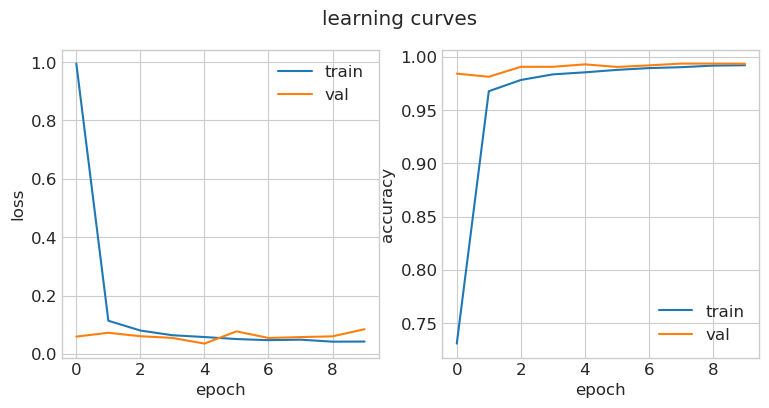

In [49]:
plot_history(history_transformer)

Training process starts quite well, but it seems that the model starts overfitting at 6th epoch. 
Again, due to lack of explicit regularization, this may be expected.

In [50]:
transformer_model.evaluate(x_test, y_test, batch_size=batch_size, verbose=1)

258/258 [==============================] - 2s 7ms/step - loss: 0.0314 - accuracy: 0.9943


[0.031439997255802155, 0.9943071603775024]

Interestingly, we did not benefit significantly from a more complex encoder. 

Finally, let us examine its pre-classifier embeddings.

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

  FutureWarning,

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

  FutureWarning,


<Figure size 800x800 with 0 Axes>

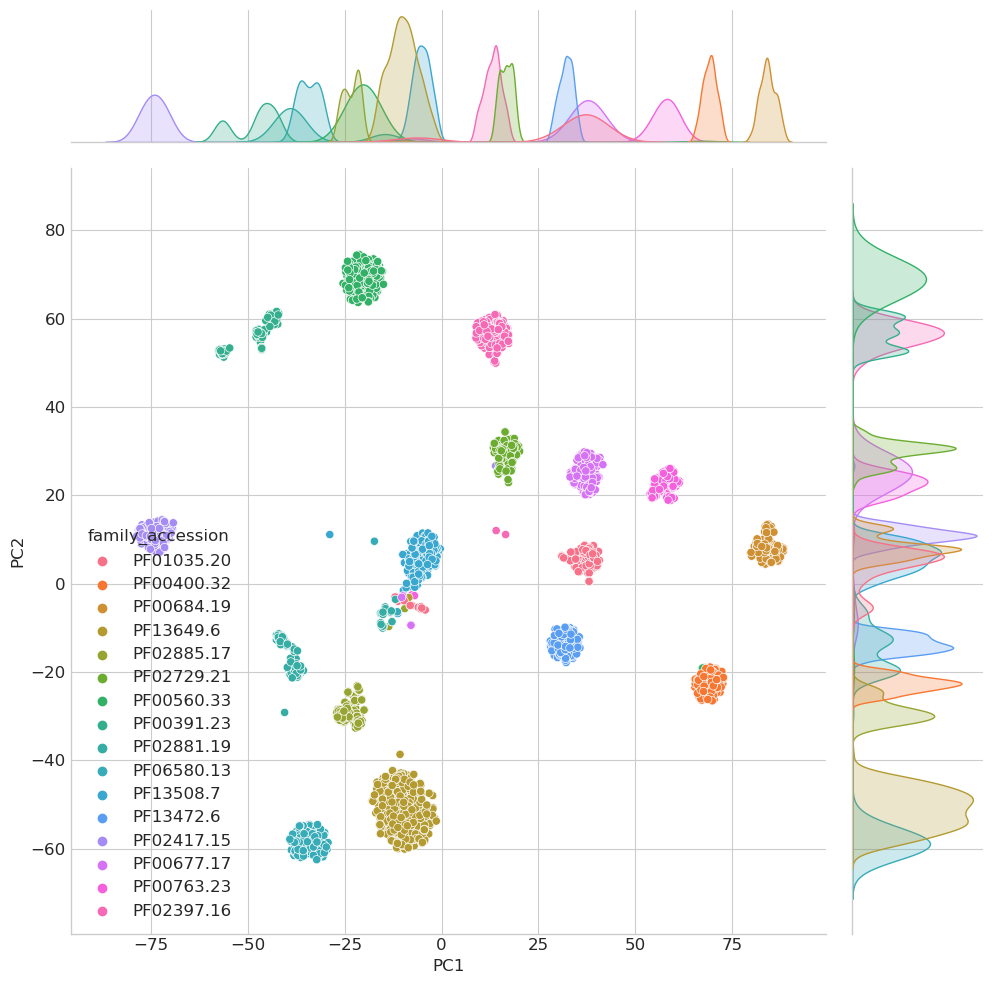

In [51]:
visualize_seq_embeddings(transformer_model, num_most_frequent_labels=16)

## Results analysis

We will start with the analysis of the **Simple Baseline** model. It achieves **99,69%** accuracy on the test set, which is a great result, given the complexity of this model.
This indicates that the model generalizes really well. Sequence embeddings visualisation shows that the model projects sequences belonging to different labels far away from each other.
Apart from that, we can see clusters of sequences belonging to the same label, and clusters are nicely separated. This is consistent with excellent performance on the test set. 
Results above indicate that amino acid embedding layer does a great job. All those observations strongly support the hypothesis that a good amino acid and consequently sequence embedding is all we need. 

Results for the **Baseline with Positional Embedding** are almost identical. However, contrary to intuition that amino acid position is important, results indicate it is not.
This can be seen because the more complex model with Positional Embedding does not perform significantly better and the simple baseline does not have any inductive bias for positions.

It is worth noting that we do not benefit from a more complex model. Introducing **two transformer layers** into the baseline model, between the amino acid embedding and the classifier head, 
does not seem to yield a stronger model. Its performance on the test set (accuracy 99,43%) indicates it performs slightly worse than simpler models above. This accuracy difference can also be seen qualitatively.
By looking at its embedding visualisation, we note that this model seems to mix-up sequences of some labels. It would be interesting to know if those labels are actually similar in terms of their biological properties. 
Such a performance of this model can be attributed to the lack of regularization and small number of training epochs. It is possible that with stronger regularization and hyperparameter search (MLP dim, embedding dim, optimizer settings) this model performs better. However, since this was not the objective of the study, I did not perform such optimization/s.

To sum up, since the baseline model performs really well and we did not improve the baseline model by introducing more complexity, there is evidence to support the hypothesis that good amino acid embeddings are all we need to perform protein sequence classification remarkably accurately.

Although this study provides strong evidence in favour of the hypothesis, it was conducted on just one dataset and apparently a very simple task. 
To reach more conclusive statements, a similar study over a wider range of datasets, tasks and model configurations is necessary. Since, due to computational resource limitations, experimental results were gathered from just a single experiment run, the study is not entirely rigorous and may not be reproducible in full. However, by repeating the same experiments above many more times, it is possible to use a paired t-test or Wilcoxon T-test to rigorously test whether introducing more complexity yields a stronger model, based on statistics on the test set. It is also worth noting that due to computational resource limitations, we performed simplified classification on only 64 labels. It would be interesting to know whether there is evidence for this hypothesis when classification is performed on the full set of labels. Another important point is the choice of metric we use to measure model performance. For the sake of simplicity, I went for model selection based on validation loss and model evaluation based on test accuracy. However, we maybe want to look into more fine-grained metrics, such as confusion matrices, per label sensitivity, specificity, F1 score and similar.


### References
- Attention is all you need (https://arxiv.org/abs/1706.03762)
- Some preprocessing ideas taken from https://www.kaggle.com/code/henrikhl/pfam-classification